## Population prior

In this notebook, we will study the BBH merger rate evolution with redshift. We approximate merger rate per comving volume at a given redshift $\mathcal{R}(z)$ as a Madau-Dickinson-like star formation rate profile,

$$ \mathcal{R}(z) = \Psi(z) \propto \frac{(1+z)^\alpha}{1 + \left (\frac{1+z}{1+c}\right)^{\alpha + \beta}}.$$

In other words, we are neglecting the time delay between star formation and merger. 
The merger rate distribution on redshift can then be written as

$$ p(z | \Lambda) \propto \frac{1}{1 + z} \frac{dV_c}{dz} \mathcal{R}(z),$$
where $dV_c /dz$ is the differential comoving volume and the $(1+z)^{-1}$ factor accounts for the translation between detector frame and source frame. Here, $\Lambda = \{\alpha, \beta, c, H_0, \Omega_m\}$ are cosmological and population parameters.

Using inversion sampling, wherein the CDF percentiles are sampled from a uniform distribution and inverted to yield an histogram over $z$. The function $p(z | \Lambda)$ will be normalized for an easier comparison with the histogram. For this exercise, we choose population parameters following the Madau-Dickinson curve: $(\alpha, \beta, c) = (2.7, 2.9, 1.9)$, $H_0 = 70 \, \text{km} \, \text{s}^{-1} \, \text{Mpc}^{-1}$ and $\Omega_m = 0.3$ with a flat $\Lambda\text{CDM}$ cosmology.

In [12]:
import sys
sys.path.append('..')
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from sirens.utils.math import sample_from_func
from sirens.utils.cosmology import flat_cosmology, luminosity_distance
from sirens.gw.event import GWEventGenerator
from sirens.inference.prior import Parameters, UniformPrior
from sirens.inference.likelihood import DrawnGWPopulationInference
from sirens.inference.population import MadauDickinsonRedshiftPrior

In [13]:
n = 2000
nevents = 500
nslice = 100
bins = 50
z = np.linspace(1e-4, 10., n)

labels = ["H0", "alpha", "beta", "c"]
plot_labels = [r"$H_0$", r"$\alpha$", r"$\beta$", r"$c$"]
# (2.7, 5.6 - 2.7, 2.9 - 1)
md_args = (2.7, 2.9, 1.9)
md_alpha, md_beta, md_c = md_args
fiducial_H0 = 70
H0_min, H0_max = 20, 140
alpha_min, alpha_max = -10, 10
beta_min, beta_max = 0., 10
c_min, c_max = 0., 4.
truths = [fiducial_H0, *md_args]

fiducial_cosmology = flat_cosmology(fiducial_H0)
sigma_dl = 0.1
z_th = 5
dl_th = luminosity_distance(fiducial_cosmology, z_th)
params = Parameters(labels, plot_labels, truths)
prior = UniformPrior(prior_min=np.array([H0_min, alpha_min, beta_min, c_min]), prior_max=np.array([H0_max, alpha_max, beta_max, c_max]))

# Generating events

z_prior = MadauDickinsonRedshiftPrior(fiducial_cosmology, z)
z_sample = sample_from_func(100000 * nevents, z_prior.eval, z, *md_args, normalize=True)

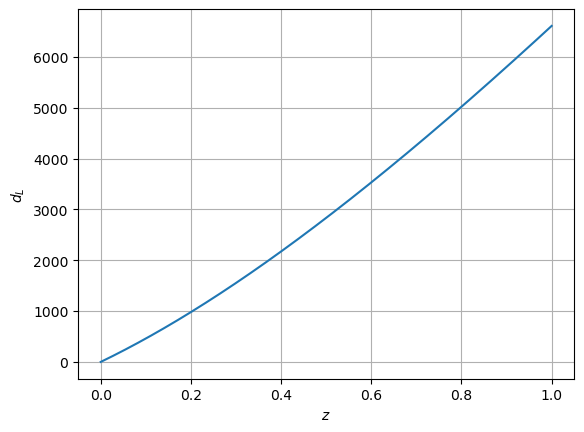

In [14]:
zz = np.linspace(0, 1, n)
plt.plot(zz, fiducial_cosmology.luminosity_distance(zz))
plt.xlabel(r'$z$')
plt.ylabel(r'$d_L$')
plt.grid()

In [15]:
@dataclass
class SFR:
    alpha : float = md_alpha
    beta : float = md_beta
    c : float = md_c

    def __call__(self):
        return (self.alpha, self.beta, self.c)

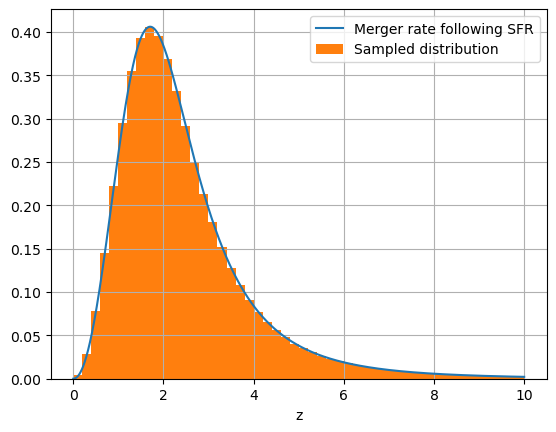

In [16]:
plt.plot(z, z_prior.eval(z, *md_args, normalize=True), label='Merger rate following SFR')
plt.hist(z_sample, bins=bins, density=True, label="Sampled distribution")
plt.xlabel('z')
plt.legend()
plt.grid()
plt.show()

The full posterior distribution for $\Lambda$ using the aforementioned redshift prior is given by 

$$ p(\Lambda) \propto \pi (\Lambda) \xi(\Lambda)^{-N_\text{det}}\prod_{i=1}^{N_\text{det}} \int \mathcal{L}(\hat{d}_L | d_L(z, H_0))p(z|\Lambda)dz,$$

with $p(z | \Lambda)$ defined above. $\mathcal{L}(\hat{d}_L | d_L(z, H_0))$ represents the single-event likelihood on the GW luminosity distance, and $\xi(\Lambda) = N_\text{det} / N_\text{obs}$ encodes the correction for selection effects due to Malmquist bias. We adopt flat priors $\pi(\Lambda)$ on all parameters, while leaving $\Omega_m$ fixed to 0.3.

The corresponding likelihood is implemented in the `DrawnGWMergerRatePriorInference` class. Let us plot some contours as a sanity check:

500 events were generated


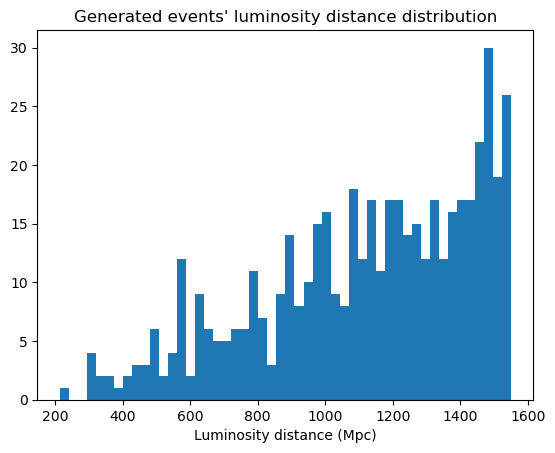

In [17]:
events = GWEventGenerator(dl_th).from_redshifts(fiducial_cosmology, z_sample, sigma_dl)[:nevents]
print(f"{len(events)} events were generated")
plt.hist([event.dl for event in events], bins=bins)
plt.title("Generated events' luminosity distance distribution")
plt.xlabel('Luminosity distance (Mpc)')
plt.show()

## Visualizing the likelihood function

In the following cells, we plot slices of the likelihood function plotted over a single parameter at a time, while the others are left fixed.

In [18]:
inference = DrawnGWPopulationInference(z_prior, events, params, prior, fiducial_H0=fiducial_H0, sigma_dl=sigma_dl, dl_th=dl_th)

20.0
[2.7, 2.9, 1.9]
21.21212121212121
[2.7, 2.9, 1.9]
22.424242424242426
[2.7, 2.9, 1.9]
23.636363636363637
[2.7, 2.9, 1.9]
24.848484848484848
[2.7, 2.9, 1.9]
26.060606060606062
[2.7, 2.9, 1.9]
27.272727272727273
[2.7, 2.9, 1.9]
28.484848484848484
[2.7, 2.9, 1.9]
29.696969696969695
[2.7, 2.9, 1.9]
30.90909090909091
[2.7, 2.9, 1.9]
32.121212121212125
[2.7, 2.9, 1.9]
33.333333333333336
[2.7, 2.9, 1.9]
34.54545454545455
[2.7, 2.9, 1.9]
35.75757575757576
[2.7, 2.9, 1.9]
36.96969696969697
[2.7, 2.9, 1.9]
38.18181818181819
[2.7, 2.9, 1.9]
39.39393939393939
[2.7, 2.9, 1.9]
40.60606060606061
[2.7, 2.9, 1.9]
41.81818181818182
[2.7, 2.9, 1.9]
43.03030303030303
[2.7, 2.9, 1.9]
44.24242424242424
[2.7, 2.9, 1.9]
45.45454545454545
[2.7, 2.9, 1.9]
46.66666666666667
[2.7, 2.9, 1.9]
47.878787878787875
[2.7, 2.9, 1.9]
49.09090909090909
[2.7, 2.9, 1.9]
50.303030303030305
[2.7, 2.9, 1.9]
51.515151515151516
[2.7, 2.9, 1.9]
52.72727272727273
[2.7, 2.9, 1.9]
53.93939393939394
[2.7, 2.9, 1.9]
55.151515151515

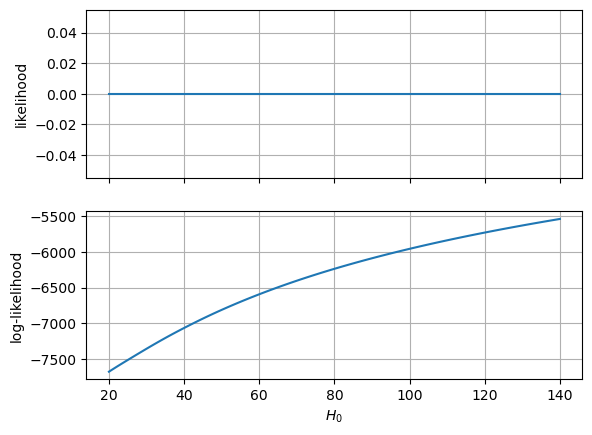

In [19]:
fig, ax = plt.subplots(2, 1, sharex=True)
H0_array = np.linspace(H0_min, H0_max, nslice)
loglike = [inference.log_likelihood((H0, *md_args)) for H0 in H0_array]
ax[0].plot(H0_array, np.exp(loglike))
ax[1].plot(H0_array, loglike)
plt.xlabel(r'$H_0$')
ax[0].set_ylabel('likelihood')
ax[1].set_ylabel('log-likelihood')

ax[0].grid()
ax[1].grid()
plt.show()

70.0
[-10.0, 2.9, 1.9]
70.0
[-9.797979797979798, 2.9, 1.9]
70.0
[-9.595959595959595, 2.9, 1.9]
70.0
[-9.393939393939394, 2.9, 1.9]
70.0
[-9.191919191919192, 2.9, 1.9]
70.0
[-8.98989898989899, 2.9, 1.9]
70.0
[-8.787878787878787, 2.9, 1.9]
70.0
[-8.585858585858587, 2.9, 1.9]
70.0
[-8.383838383838384, 2.9, 1.9]
70.0
[-8.181818181818182, 2.9, 1.9]
70.0
[-7.979797979797979, 2.9, 1.9]
70.0
[-7.777777777777778, 2.9, 1.9]
70.0
[-7.575757575757576, 2.9, 1.9]
70.0
[-7.373737373737374, 2.9, 1.9]
70.0
[-7.171717171717171, 2.9, 1.9]
70.0
[-6.96969696969697, 2.9, 1.9]
70.0
[-6.767676767676768, 2.9, 1.9]
70.0
[-6.565656565656566, 2.9, 1.9]
70.0
[-6.363636363636363, 2.9, 1.9]
70.0
[-6.161616161616162, 2.9, 1.9]
70.0
[-5.959595959595959, 2.9, 1.9]
70.0
[-5.757575757575758, 2.9, 1.9]
70.0
[-5.555555555555555, 2.9, 1.9]
70.0
[-5.353535353535354, 2.9, 1.9]
70.0
[-5.151515151515151, 2.9, 1.9]
70.0
[-4.94949494949495, 2.9, 1.9]
70.0
[-4.747474747474747, 2.9, 1.9]
70.0
[-4.545454545454546, 2.9, 1.9]
70.0
[-4

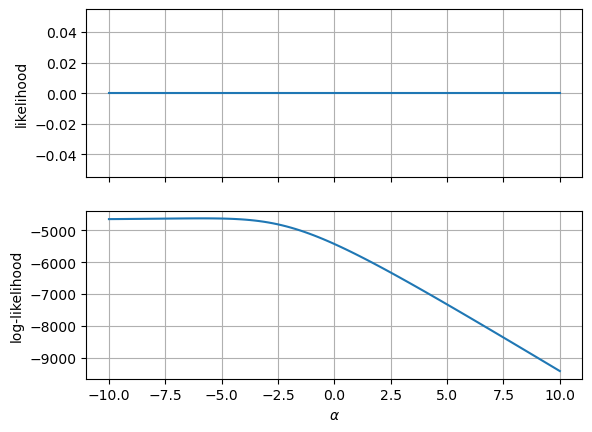

In [20]:
fig, ax = plt.subplots(2, 1, sharex=True)
alpha_array = np.linspace(alpha_min, alpha_max, nslice)
loglike = [inference.log_likelihood((fiducial_H0, *SFR(alpha=alpha)())) for alpha in alpha_array]
ax[0].plot(alpha_array, np.exp(loglike))
ax[1].plot(alpha_array, loglike)
plt.xlabel(r'$\alpha$')
ax[0].set_ylabel('likelihood')
ax[1].set_ylabel('log-likelihood')
ax[0].grid()
ax[1].grid()
plt.show()

70.0
[2.7, 0.0, 1.9]
70.0
[2.7, 0.10101010101010101, 1.9]
70.0
[2.7, 0.20202020202020202, 1.9]
70.0
[2.7, 0.30303030303030304, 1.9]
70.0
[2.7, 0.40404040404040403, 1.9]
70.0
[2.7, 0.5050505050505051, 1.9]
70.0
[2.7, 0.6060606060606061, 1.9]
70.0
[2.7, 0.7070707070707071, 1.9]
70.0
[2.7, 0.8080808080808081, 1.9]
70.0
[2.7, 0.9090909090909091, 1.9]
70.0
[2.7, 1.0101010101010102, 1.9]
70.0
[2.7, 1.1111111111111112, 1.9]
70.0
[2.7, 1.2121212121212122, 1.9]
70.0
[2.7, 1.3131313131313131, 1.9]
70.0
[2.7, 1.4141414141414141, 1.9]
70.0
[2.7, 1.5151515151515151, 1.9]
70.0
[2.7, 1.6161616161616161, 1.9]
70.0
[2.7, 1.7171717171717171, 1.9]
70.0
[2.7, 1.8181818181818181, 1.9]
70.0
[2.7, 1.9191919191919191, 1.9]
70.0
[2.7, 2.0202020202020203, 1.9]
70.0
[2.7, 2.121212121212121, 1.9]
70.0
[2.7, 2.2222222222222223, 1.9]
70.0
[2.7, 2.323232323232323, 1.9]
70.0
[2.7, 2.4242424242424243, 1.9]
70.0
[2.7, 2.525252525252525, 1.9]
70.0
[2.7, 2.6262626262626263, 1.9]
70.0
[2.7, 2.727272727272727, 1.9]
70.0
[2

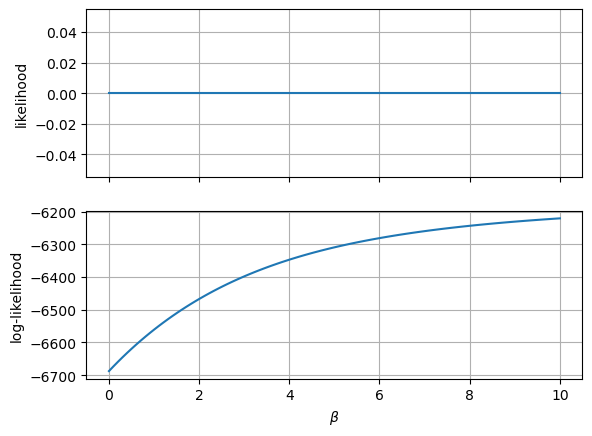

In [21]:
fig, ax = plt.subplots(2, 1, sharex=True)
beta_array = np.linspace(beta_min, beta_max, nslice)
loglike = [inference.log_likelihood((fiducial_H0, *SFR(beta=beta)())) for beta in beta_array]
ax[0].plot(beta_array,  np.exp(loglike))
ax[1].plot(beta_array, loglike)
plt.xlabel(r'$\beta$')
ax[0].set_ylabel('likelihood')
ax[1].set_ylabel('log-likelihood')
ax[0].grid()
ax[1].grid()
plt.show()

70.0
[2.7, 2.9, 0.0]
70.0
[2.7, 2.9, 0.04040404040404041]


70.0
[2.7, 2.9, 0.08080808080808081]
70.0
[2.7, 2.9, 0.12121212121212122]
70.0
[2.7, 2.9, 0.16161616161616163]
70.0
[2.7, 2.9, 0.20202020202020204]
70.0
[2.7, 2.9, 0.24242424242424243]
70.0
[2.7, 2.9, 0.2828282828282829]
70.0
[2.7, 2.9, 0.32323232323232326]
70.0
[2.7, 2.9, 0.36363636363636365]
70.0
[2.7, 2.9, 0.4040404040404041]
70.0
[2.7, 2.9, 0.4444444444444445]
70.0
[2.7, 2.9, 0.48484848484848486]
70.0
[2.7, 2.9, 0.5252525252525253]
70.0
[2.7, 2.9, 0.5656565656565657]
70.0
[2.7, 2.9, 0.6060606060606061]
70.0
[2.7, 2.9, 0.6464646464646465]
70.0
[2.7, 2.9, 0.686868686868687]
70.0
[2.7, 2.9, 0.7272727272727273]
70.0
[2.7, 2.9, 0.7676767676767677]
70.0
[2.7, 2.9, 0.8080808080808082]
70.0
[2.7, 2.9, 0.8484848484848485]
70.0
[2.7, 2.9, 0.888888888888889]
70.0
[2.7, 2.9, 0.9292929292929294]
70.0
[2.7, 2.9, 0.9696969696969697]
70.0
[2.7, 2.9, 1.0101010101010102]
70.0
[2.7, 2.9, 1.0505050505050506]
70.0
[2.7, 2.9, 1.090909090909091]
70.0
[2.7, 2.9, 1.1313131313131315]
70.0
[2.7, 2.9, 1.17171

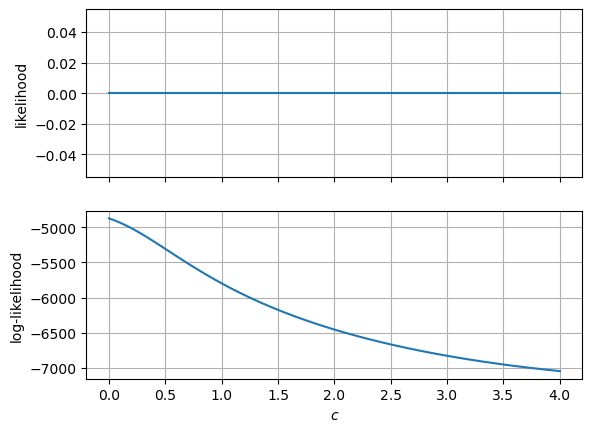

In [22]:
fig, ax = plt.subplots(2, 1, sharex=True)
c_array = np.linspace(c_min, c_max, nslice)
loglike = [inference.log_likelihood((fiducial_H0, *SFR(c=c)())) for c in c_array]
ax[0].plot(c_array, np.exp(loglike))
ax[1].plot(c_array, loglike)
plt.xlabel(r'$c$')
ax[0].set_ylabel('likelihood')
ax[1].set_ylabel('log-likelihood')
ax[0].grid()
ax[1].grid()
plt.show()